## LLM Misinformation Analysis

In this project ...

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from helper_functions import pre_process_text_only, clean_text

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Initializing Data

In [2]:
# upload datasets
fake = pd.read_csv("Data\Fake.csv")
fake_df = pd.DataFrame(fake)

real = pd.read_csv("Data\True.csv")
real_df = pd.DataFrame(real)

fake_df['label'] = 1
real_df['label'] = 0

combined_df = pd.concat([fake_df, real_df], axis=0).reset_index(drop=True)
combined_df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


#### Data Cleaning

In [3]:
# Preprocess
required_cols = ['text', 'title', 'subject']

# If 'text' column doesn't exist but 'content' does, rename it
if 'text' not in combined_df.columns and 'content' in combined_df.columns:
    combined_df.rename(columns={'content': 'text'}, inplace=True)

# Ensure we have text content to work with
if 'text' not in combined_df.columns:
    # If no text column, try to use title as text
    if 'title' in combined_df.columns:
        combined_df['text'] = combined_df['title']
    else:
        raise ValueError("Neither 'text' nor 'title' columns found in dataset")

# Drop rows with missing text
combined_df = combined_df.dropna(subset=['text'])

# Shuffle the data
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True) 
df

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0
...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",1
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",0
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",0
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",1


#### Data Pre-Processing/Feature Extraction and Selection

In [4]:
# Data pre-processing
stop_words = set(stopwords.words('english'))
# Strip words to its base form 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Fill nulls and combine title and text
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')
df['content'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['content'].apply(clean_text)
df_clean = df
df_clean


,title,text,subject,date,label,content,cleaned_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court committed ‘cou...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...
...,...,...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",1,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,unreal cbs’s ted koppel tell sean hannity he’s...
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",0,PM May seeks to ease Japan's Brexit fears duri...,pm may seek ease japan brexit fear trade visit...
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",0,Merkel: Difficult German coalition talks can r...,merkel difficult german coalition talk reach d...
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",1,Trump Stole An Idea From North Korean Propaga...,trump stole idea north korean propaganda parod...


In [5]:
# Feature Extraction
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_clean['cleaned_text'])
y = df_clean['label']

#### Implementing a Random Forest Classifier

In [6]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4284
           1       1.00      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



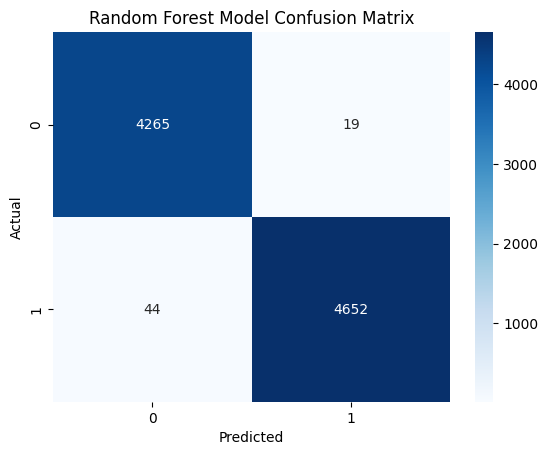

In [7]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

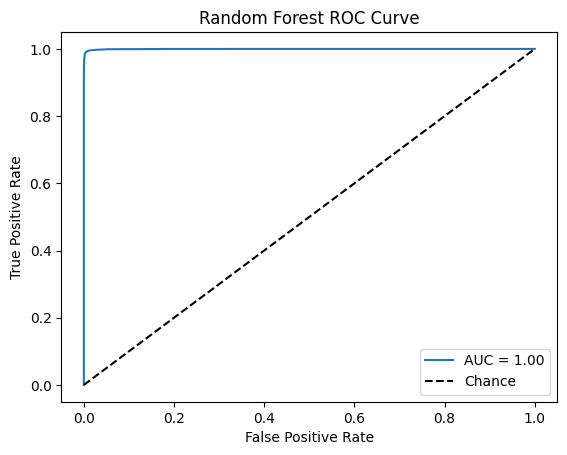

In [8]:
from sklearn.metrics import roc_curve, auc
probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Implementing a Logistic Regression (Classifier)

In [9]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)


y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



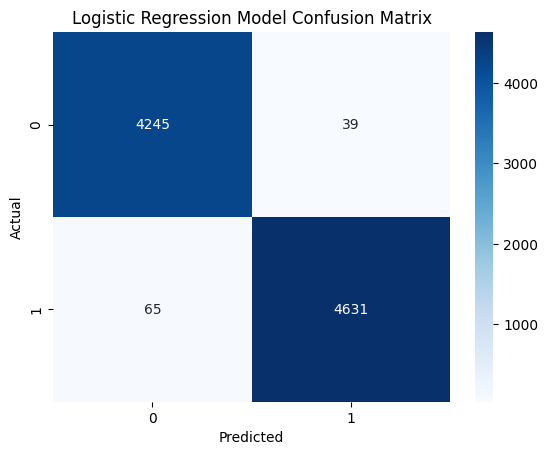

In [10]:
lr_cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

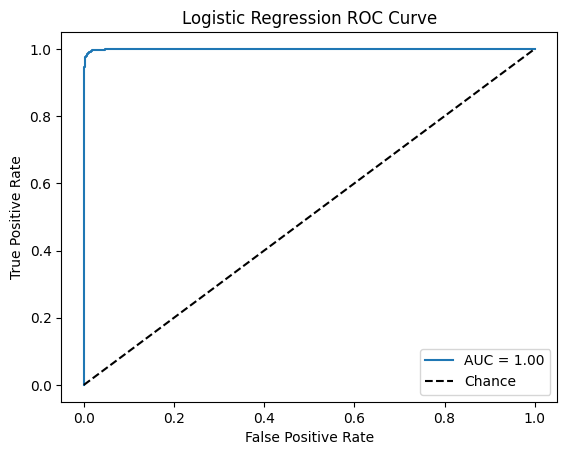

In [11]:
from sklearn.metrics import roc_curve, auc
probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Testing new data on the models 

Purpose:

We are using two new datasets that we will use to make another logistic regression and random forest model. As such we have to repeat the preprocessing and feature extraction for again, adjusting for the columns and elements of this dataset. We will then test the model's performance after it has been trained on the new data and we will also test the prior the models trained with the old data on the new data. The goal of this is to see how much effect train-test-split has on model accuracy and performance and whether it biases our model scores. This will additionally give more insight into the importance of locally training classification models on specific datasets rather than random ones. 

#### Pre-Processing

In [12]:
# upload datasets
fake2 = pd.read_csv("Data\DataSet_Misinfo_FAKE.csv")
fake_df2 = pd.DataFrame(fake2)

real2 = pd.read_csv("Data\DataSet_Misinfo_TRUE.csv")
real_df2 = pd.DataFrame(real2)

fake_df2['label'] = 1
real_df2['label'] = 0

combined_df2 = pd.concat([fake_df2, real_df2], axis=0)
combined_df2 = combined_df2.drop(columns='Unnamed: 0')

df2 = combined_df2.sample(frac=1, random_state=42).reset_index(drop=True) 
df2

,text,label
0,Former Prime Minister Silvio Berlusconi said o...,0
1,The EU makes use of migrant crisis to create o...,1
2,Philippine security forces on Sunday arrested ...,0
3,You are here: Home / US / 6 Brutal Truths Abou...,1
4,Sometimes the Deep State isn’t so deep. For s...,0
...,...,...
78612,Miss Universe 1996 Alicia Machado is now an Am...,1
78613,The United States will expand its program help...,0
78614,A new intelligence report commissioned by the ...,0
78615,Jesus f*cking Christ our President* is a moron...,1


In [13]:
# Data pre-processing
stop_words1 = set(stopwords.words('english'))

# Strip words to its base form 
lemmatizer1 = WordNetLemmatizer()

def clean_text1(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer1.lemmatize(word) for word in text.split() if word not in stop_words1])
    return text

# Fill nulls and clean text
df2['text'] = df2['text'].fillna('')
df2['cleaned_text'] = df2['text'].apply(clean_text1)

df2_clean = df2
df2_clean

,text,label,cleaned_text
0,Former Prime Minister Silvio Berlusconi said o...,0,former prime minister silvio berlusconi said t...
1,The EU makes use of migrant crisis to create o...,1,eu make use migrant crisis create occupation a...
2,Philippine security forces on Sunday arrested ...,0,philippine security force sunday arrested indo...
3,You are here: Home / US / 6 Brutal Truths Abou...,1,home u brutal truth democrat election revealed...
4,Sometimes the Deep State isn’t so deep. For s...,0,sometimes deep state isn’t deep something that...
...,...,...,...
78612,Miss Universe 1996 Alicia Machado is now an Am...,1,miss universe alicia machado american citizen ...
78613,The United States will expand its program help...,0,united state expand program helping thousand p...
78614,A new intelligence report commissioned by the ...,0,new intelligence report commissioned white hou...
78615,Jesus f*cking Christ our President* is a moron...,1,jesus fcking christ president moron satisfied ...


In [14]:
# Feature Extraction 
tfidf = TfidfVectorizer()
X1 = tfidf.fit_transform(df2['cleaned_text'])
y1 = df2['label']

#### Training the models on new data and testing 

In [ ]:
# Train-test-split the new dataset (dataset 2) to re-train model on it
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42)

# Define the Model
rf_model2 = RandomForestClassifier()
rf_model2.fit(X_train1, y_train1)

# Predict the data 
y_pred_rf2 = rf_model2.predict(X_test1)
print(classification_report(y_test1, y_pred_rf2))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6995
           1       0.94      0.94      0.94      8729

    accuracy                           0.94     15724
   macro avg       0.93      0.93      0.93     15724
weighted avg       0.94      0.94      0.94     15724



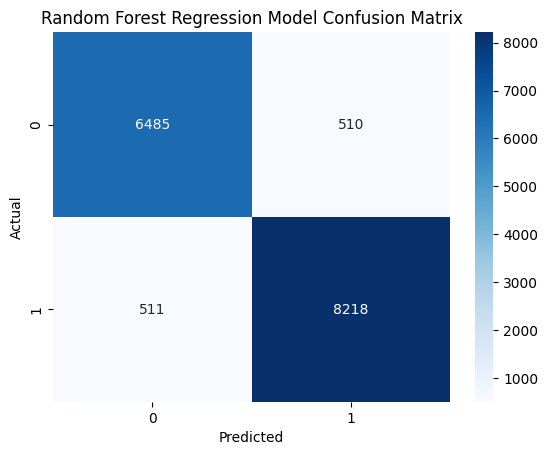

In [ ]:
# RF Confusion Matrix -- Re-trained model
rf_cm2 = confusion_matrix(y_test1, y_pred_rf2)
sns.heatmap(rf_cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Regression Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

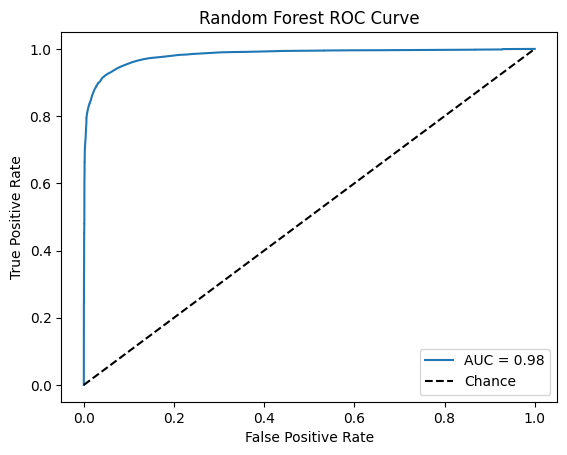

In [ ]:
# ROC Curve
probs1 = rf_model2.predict_proba(X_test1)[:,1]
fpr1, tpr1, _ = roc_curve(y_test1, probs1)
roc_auc1 = auc(fpr1, tpr1)

plt.figure()
plt.plot(fpr1, tpr1, label=f'AUC = {roc_auc1:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42)

# Define the logistic regression model 
lr_model2 = LogisticRegression()
lr_model2.fit(X_train1, y_train1)

# Predict the data 
y_pred_lr2 = lr_model2.predict(X_test1)
print(classification_report(y_test1, y_pred_lr2))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      6995
           1       0.94      0.96      0.95      8729

    accuracy                           0.94     15724
   macro avg       0.94      0.94      0.94     15724
weighted avg       0.94      0.94      0.94     15724



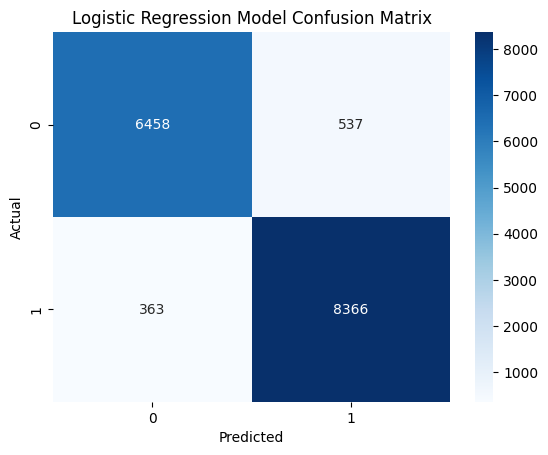

In [ ]:
# LR Model Confusion Matrix (Re-trained)
cm_lr2 = confusion_matrix(y_test1, y_pred_lr2)
sns.heatmap(cm_lr2, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

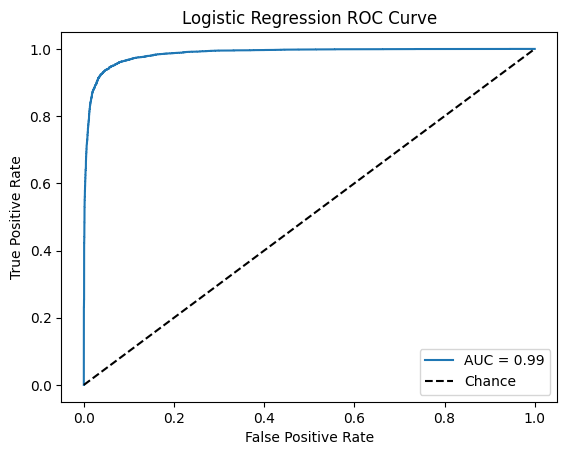

In [ ]:
# LR ROC Curve
probs2 = lr_model2.predict_proba(X_test1)[:,1]
fpr2, tpr2, _ = roc_curve(y_test1, probs2)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr2, tpr2, label=f'AUC = {roc_auc2:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Testing Models on New Data

We took the second model trained on dataset 2 and tested it on a the new data (dataset 3)

In [22]:
# Uploading Dataset 3
dataset_3 = pd.read_csv(r"C:\Users\aidan\OneDrive - The University of Chicago\UChicago Year 3\Data 259 - Data Ethics\Project\Data-Ethics-Misinformation-Project\Data\fake_and_real_news.csv")
dataset_3_df = pd.DataFrame(dataset_3)
dataset_3_df['label'] = dataset_3['label'].replace({'Fake': 1, 'Real': 0})
dataset_3_df.columns = dataset_3_df.columns.str.lower()
dataset_3_df = dataset_3_df.dropna()
df3 = dataset_3_df.sample(frac=1, random_state=42)

df3_clean = pre_process_text_only(df3)
df3_clean

,text,label,cleaned_text
8432,Trump’s Involvement In Houston Chemical Plant...,1,trump’s involvement houston chemical plant exp...
5680,"U.S. Senate votes near unanimously for Russia,...",0,u senate vote near unanimously russia iran san...
4767,White and male: broader bureaucracy mirrors Tr...,0,white male broader bureaucracy mirror trump ca...
9218,"Trump, Modi call North Korea's 'grave threat' ...",0,trump modi call north korea grave threat peace...
621,"Ivanka Trump Shares Famous Jewish Quote, But ...",1,ivanka trump share famous jewish quote hilario...
...,...,...,...
5734,WATCH: Hannity Loses His Sh*t And Refers To H...,1,watch hannity loses sht refers hillary ‘presid...
5191,Sean Hannity Just Showed EXACTLY How Delusion...,1,sean hannity showed exactly delusional conserv...
5390,WATCH: CNN Host Makes Trump’s Campaign Manage...,1,watch cnn host make trump’s campaign manager r...
860,Democratic senator lifts hold on Trump antitru...,0,democratic senator lift hold trump antitrust n...


In [23]:
# Vectorize
# Note to self: .transform() instead of .fit_transform() when matching feature size for Vectorization for cross-testing
X3 = tfidf.transform(df3_clean['cleaned_text'])
y3 = df3_clean['label']

Model test performance on dataset 3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4900
           1       0.99      0.99      0.99      5000

    accuracy                           0.99      9900
   macro avg       0.99      0.99      0.99      9900
weighted avg       0.99      0.99      0.99      9900



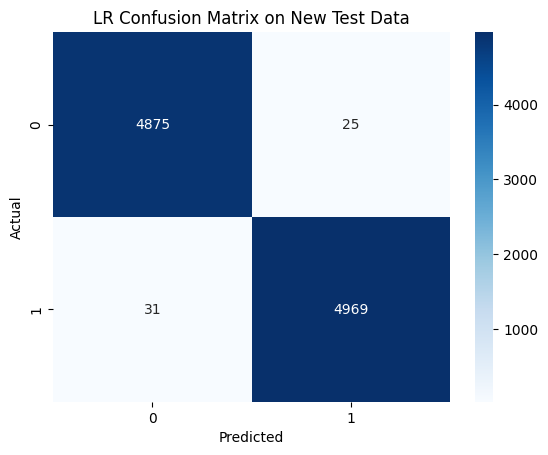

In [24]:
# Testing  model on new data
# lr_model2 was trained with dataset 2 and is now predicting dataset 3
y_pred_no = lr_model2.predict(X3)
print("Model test performance on dataset 3")
print(classification_report(y3, y_pred_no))

cm_no = confusion_matrix(y3, y_pred_no)
sns.heatmap(cm_no, annot=True, fmt='d', cmap='Blues')
plt.title('LR Confusion Matrix on New Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

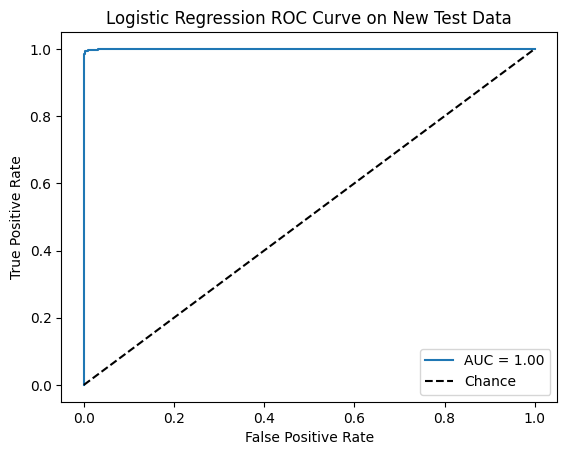

In [ ]:
# ROC Curve
probs3 = lr_model2.predict_proba(X3)[:,1]
l_fpr2, l_tpr2, _ = roc_curve(y3, probs3)
lr_roc_auc2 = auc(l_fpr2, l_tpr2)

plt.figure()
plt.plot(l_fpr2, l_tpr2, label=f'AUC = {lr_roc_auc2:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve on New Test Data')
plt.legend(loc='lower right')
plt.show()

Model test performance on dataset 3
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4900
           1       0.99      1.00      0.99      5000

    accuracy                           0.99      9900
   macro avg       0.99      0.99      0.99      9900
weighted avg       0.99      0.99      0.99      9900



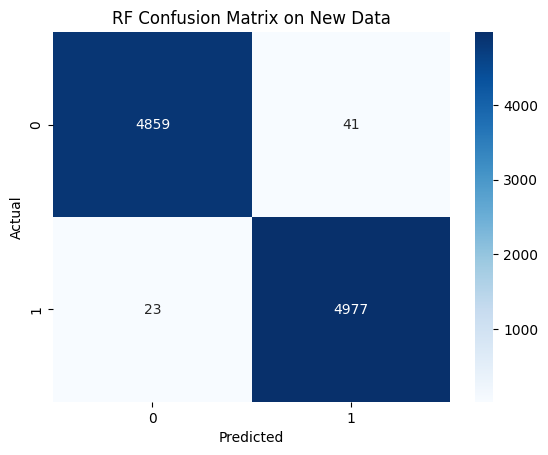

In [ ]:
# Random Forest Classifier confusion matrix
y_pred_no_rf = rf_model2.predict(X3)
print("Model test performance on dataset 3")
print(classification_report(y3, y_pred_no_rf))

cm_no_rf = confusion_matrix(y3, y_pred_no_rf)
sns.heatmap(cm_no_rf, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix on New Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

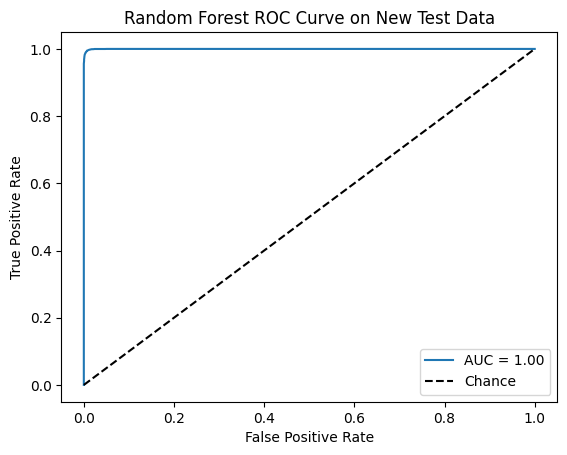

In [ ]:
# Random Forest ROC Curve
probs4 = rf_model2.predict_proba(X3)[:,1]
fpr4, tpr4, _ = roc_curve(y3, probs4)
lr_roc_auc4 = auc(fpr4, tpr4)

plt.figure()
plt.plot(fpr4, tpr4, label=f'AUC = {lr_roc_auc4:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve on New Test Data')
plt.legend(loc='lower right')
plt.show()

#### Testing Another Dataset (Dataset 4)

In [33]:
# Uploading dataset 4
data4 = pd.read_csv("Data\Fake_or_Real.csv")
df4 = pd.DataFrame(data4)
df4 = df4.drop(columns=['Unnamed: 0'])
df4['label'] = df4['label'].replace({'FAKE': 1, 'REAL': 0})

df4 = df4.sample(frac=1, random_state=42).reset_index(drop=True)
df4

,title,text,label
0,"American Dream, Revisited",Will Trump pull a Brexit times ten? What would...,1
1,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,1
2,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,1
3,Confirmed: Public overwhelmingly (10-to-1) say...,Print \n[Ed. – Every now and then the facade c...,1
4,Nanny In Jail After Force Feeding Baby To Death,Nanny In Jail After Force Feeding Baby To Deat...,1
...,...,...,...
6330,The inane spectacle of the GOP debate: Cruz th...,What happened was less a debate among contende...,0
6331,"Clinton, FBIGate and the true depth of the Oba...","Clinton, FBIGate and the true depth of the Oba...",1
6332,"Fearing Election Day Trouble, Some US Schools ...","Fearing Election Day Trouble, Some US Schools ...",1
6333,Obama gets away with some whoppers on guns at ...,President Obama’s appearance at a town hall me...,0


In [35]:
# Data Preprocess
stop_words = set(stopwords.words('english'))
# Strip words to its base form 
lemmatizer = WordNetLemmatizer()

df4['text'] = df4['text'].fillna('')
df4['title'] = df4['title'].fillna('')
df4['content'] = df4['title'] + ' ' + df4['text']
df4['cleaned_text'] = df4['content'].apply(clean_text)

df4_clean = df4.drop(columns=['title', 'content'])
df4_clean

,text,label,cleaned_text
0,Will Trump pull a Brexit times ten? What would...,1,american dream revisited trump pull brexit tim...
1,Clintons Are Under Multiple FBI Investigations...,1,clinton multiple fbi investigation agent stymi...
2,Dispatches from Eric Zuesse This piece is cros...,1,fbi can’t actually investigate candidate hilla...
3,Print \n[Ed. – Every now and then the facade c...,1,confirmed public overwhelmingly say medium wan...
4,Nanny In Jail After Force Feeding Baby To Deat...,1,nanny jail force feeding baby death nanny jail...
...,...,...,...
6330,What happened was less a debate among contende...,0,inane spectacle gop debate cruz showboating cr...
6331,"Clinton, FBIGate and the true depth of the Oba...",1,clinton fbigate true depth obamageddon clinton...
6332,"Fearing Election Day Trouble, Some US Schools ...",1,fearing election day trouble u school cancel c...
6333,President Obama’s appearance at a town hall me...,0,obama get away whopper gun town hall event pre...


In [36]:
# Vectorize the data
X4 = tfidf.transform(df4_clean['cleaned_text'])
y4 = df4_clean['label']

Model test performance on dataset 4
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      3171
           1       0.83      0.96      0.89      3164

    accuracy                           0.88      6335
   macro avg       0.89      0.88      0.88      6335
weighted avg       0.89      0.88      0.88      6335



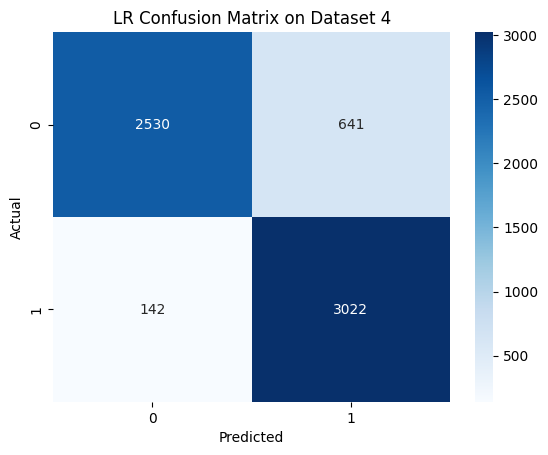

In [45]:
# Testing Logistic Regression 3

y_pred_lr4 = lr_model2.predict(X4)
print("Model test performance on dataset 4")
print(classification_report(y4, y_pred_lr4))

cm_lr4 = confusion_matrix(y4, y_pred_lr4)
sns.heatmap(cm_lr4, annot=True, fmt='d', cmap='Blues')
plt.title('LR Confusion Matrix on Dataset 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

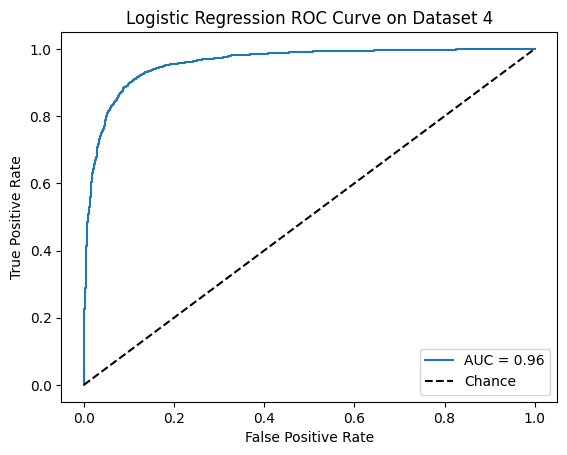

In [40]:
# ROC Curve for LR
probslr4 = lr_model2.predict_proba(X4)[:,1]
l_fpr3, l_tpr3, _ = roc_curve(y4, probslr4)
lr_roc_auc3 = auc(l_fpr3, l_tpr3)

plt.figure()
plt.plot(l_fpr3, l_tpr3, label=f'AUC = {lr_roc_auc3:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve on Dataset 4')
plt.legend(loc='lower right')
plt.show()

Model test performance on dataset 4
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3171
           1       0.95      0.99      0.97      3164

    accuracy                           0.97      6335
   macro avg       0.97      0.97      0.97      6335
weighted avg       0.97      0.97      0.97      6335



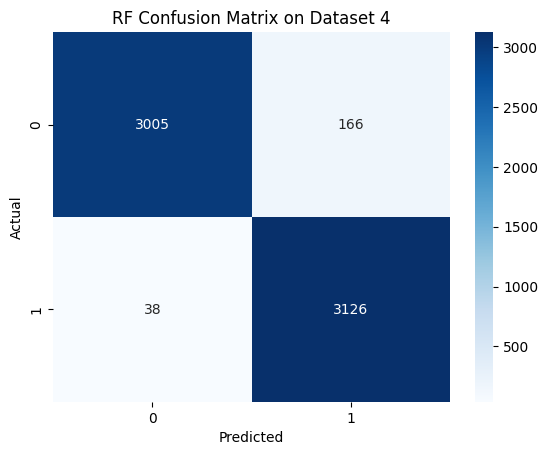

In [42]:
# Random Forest Classifier confusion matrix (dataset 4)
y_pred_rf4 = rf_model2.predict(X4)
print("Model test performance on dataset 4")
print(classification_report(y4, y_pred_rf4))

cmrf4 = confusion_matrix(y4, y_pred_rf4)
sns.heatmap(cmrf4, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix on Dataset 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

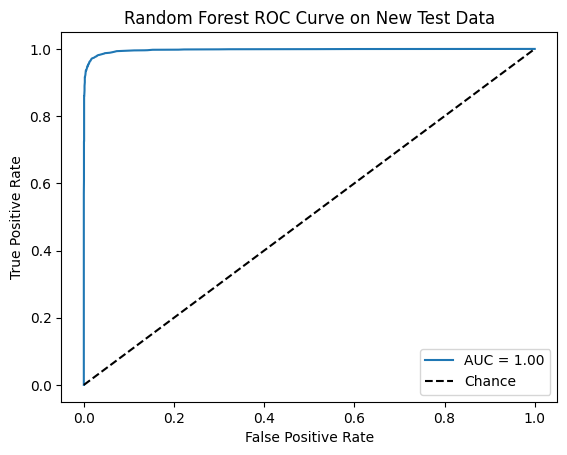

In [43]:
# Random Forest ROC Curve
probs5 = rf_model2.predict_proba(X4)[:,1]
fpr5, tpr5, _ = roc_curve(y4, probs5)
lr_roc_auc5 = auc(fpr5, tpr5)

plt.figure()
plt.plot(fpr5, tpr5, label=f'AUC = {lr_roc_auc5:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve on New Test Data')
plt.legend(loc='lower right')
plt.show()